In [1]:
# -------------------------------------------------------------------------------
# Name: main.py
# Purpose: Pull data from twitter, perform sentiment analysis and pull stock data
#
# Author(s):    David Little
#
# Created:      04/26/2021
# Updated:
# Update Comment(s):
#
# TO DO:
#
# -------------------------------------------------------------------------------


import requests
import pandas as pd
import time
import regex as re
from datetime import datetime, timedelta

In [3]:
def get_data(tweet):
    data = {
        'id': tweet['id'],
        'created_at': tweet['created_at'],
        'text': tweet['text'],
        'retweet_count': tweet['public_metrics']['retweet_count'],
        'like_count': tweet['public_metrics']['like_count'],
        'reply_count': tweet['public_metrics']['reply_count']
#        'quote_count': tweet['public_metrics']['quote_count']
    }
    return data

In [4]:
whitespace = re.compile(r"\s+")
web_address = re.compile(r"(?i)http(s):\/\/[a-z0-9.~_\-\/]+")
tesla = re.compile(r"(?i)@Tesla(?=\b)")
user = re.compile(r"(?i)@[a-z0-9_]+")

In [5]:
#------------------------------------- Twitter Pull  --------------------------------------------------------

# setup the API request
endpoint = 'https://api.twitter.com/2/tweets/search/recent'  # 'https://api.twitter.com/2/tweets/search/all'
headers = {'authorization': f'Bearer {BEARER_TOKEN}'}
params = {
    'query': '(tesla OR tsla OR elon musk and -spacex) (lang:en) -is:retweet',
    'max_results': '100',
    'tweet.fields': 'created_at,lang,public_metrics'
        }

In [6]:
dtformat = '%Y-%m-%dT%H:%M:%SZ'  # the date format string required by twitter

# we use this function to subtract 60 mins from our datetime string
def time_travel(now, mins):
    now = datetime.strptime(now, dtformat)
    back_in_time = now - timedelta(minutes=mins)
    return back_in_time.strftime(dtformat)

In [7]:
now = datetime.now()  # get the current datetime, this is our starting point
last_week = now - timedelta(days=6)  # datetime one week ago = the finish line
now = now.strftime(dtformat)  # convert now datetime to format for API
now

'2021-08-19T12:04:43Z'

In [8]:
df = pd.DataFrame()  # initialize dataframe to store tweets
while True:
    if datetime.strptime(now, dtformat) < last_week:
        # if we have reached 6 days ago, break the loop
        break
    pre60 = time_travel(now, 5)  # get x minutes before 'now'
    # assign from and to datetime parameters for the API
    params['start_time'] = pre60
    params['end_time'] = now
    response = requests.get(endpoint,
                            params=params,
                            headers=headers)  # send the request
    time.sleep(2)
    now = pre60  # move the window 60 minutes earlier
    # iteratively append our tweet data to our dataframe
    for tweet in response.json()['data']:
        row = get_data(tweet)  # we defined this function earlier
        if row['like_count']>=1 and row['retweet_count']>=1 and row['reply_count']>=0:   #row['like_count'] >=3:
            df = df.append(row, ignore_index=True)
df

,created_at,id,like_count,reply_count,retweet_count,text
0,2021-08-19T12:04:28.000Z,1428327001916678148,106.0,85.0,84.0,💥It’s #NFTgiveaway time with the Angry Boars N...
1,2021-08-19T12:02:23.000Z,1428326476584308736,32.0,4.0,3.0,"*Update: the latest count is 14 for EU (!), wi..."
2,2021-08-19T12:02:00.000Z,1428326378500280333,73.0,16.0,5.0,"Every day, I'll write about breaking news stor..."
3,2021-08-19T12:01:53.000Z,1428326350935449601,3.0,0.0,1.0,TSLA Key levels before open. https://t.co/lDQo...
4,2021-08-19T12:01:39.000Z,1428326290864721925,3.0,0.0,1.0,@kallemets argues that as has happened with Te...
...,...,...,...,...,...,...
12252,2021-08-13T12:09:07.000Z,1426153841402302465,14.0,2.0,2.0,This is quite the equivocation. Esp from someo...
12253,2021-08-13T12:08:04.000Z,1426153577660157952,4.0,0.0,1.0,Tesla's Musk hopes to make first cars at Berli...
12254,2021-08-13T12:07:02.000Z,1426153318443888663,30.0,7.0,10.0,Watching Elon Musk and Armin Laschet give a pr...
12255,2021-08-13T12:05:11.000Z,1426152852808994817,1.0,1.0,1.0,@BabyDogeCoin @Tesla @elonmusk Great 😉👍


In [9]:
#---------------------------------------------- Sentiment Model ------------------------------------------------------

import flair
sentiment_model = flair.models.TextClassifier.load('en-sentiment')

# we will append probability and sentiment preds later
probs = []
sentiments = []
clean_tweets = []
timestamp = []
binary = []

for time in df['created_at']:
    timestamp.append(((datetime.strptime(time, '%Y-%m-%dT%H:%M:%S.%fZ')
                      - timedelta(hours = 4)) #timezone
                      + timedelta(hours = 0) #delay
                     ).strftime('%Y-%m-%d')) #%H:00:00'))

for tweet in df['text']:
# we then use the sub method to replace anything matching
    tweet = whitespace.sub(' ', tweet)
    tweet = web_address.sub('', tweet)
    tweet = tesla.sub('Tesla', tweet)
    tweet = user.sub('', tweet)
    sentence = flair.data.Sentence(tweet)
    sentiment_model.predict(sentence)
    # extract sentiment prediction
    sentiments.append(sentence.labels[0].value)  # 'POSITIVE' or 'NEGATIVE'
    if sentence.labels[0].value == 'NEGATIVE':
        probs.append(-1 * sentence.labels[0].score)  # numerical score 0-1
        binary.append(0)
    else:
        probs.append(sentence.labels[0].score)  # numerical score 0-1
        binary.append(1)
    clean_tweets.append(tweet)
    # print(tweet)
    # print(' ')

# add probability and sentiment predictions to tweets dataframe
df['text_clean'] = clean_tweets
df['probability'] = probs
df['sentiment'] = sentiments
df['binary'] = binary
df['Date'] = timestamp
#df['Date'] = pd.to_datetime(df['Date'])
df

2021-08-19 13:13:07,404 loading file C:\Users\djlittle\.flair\models\sentiment-en-mix-distillbert_4.pt


,created_at,id,like_count,reply_count,retweet_count,text,text_clean,probability,sentiment,binary,Date
0,2021-08-19T12:04:28.000Z,1428327001916678148,106.0,85.0,84.0,💥It’s #NFTgiveaway time with the Angry Boars N...,💥It’s #NFTgiveaway time with the Angry Boars N...,0.999459,POSITIVE,1,2021-08-19
1,2021-08-19T12:02:23.000Z,1428326476584308736,32.0,4.0,3.0,"*Update: the latest count is 14 for EU (!), wi...","*Update: the latest count is 14 for EU (!), wi...",-0.998192,NEGATIVE,0,2021-08-19
2,2021-08-19T12:02:00.000Z,1428326378500280333,73.0,16.0,5.0,"Every day, I'll write about breaking news stor...","Every day, I'll write about breaking news stor...",0.858370,POSITIVE,1,2021-08-19
3,2021-08-19T12:01:53.000Z,1428326350935449601,3.0,0.0,1.0,TSLA Key levels before open. https://t.co/lDQo...,TSLA Key levels before open.,-0.995029,NEGATIVE,0,2021-08-19
4,2021-08-19T12:01:39.000Z,1428326290864721925,3.0,0.0,1.0,@kallemets argues that as has happened with Te...,argues that as has happened with Tesla in the...,0.752828,POSITIVE,1,2021-08-19
...,...,...,...,...,...,...,...,...,...,...,...
12252,2021-08-13T12:09:07.000Z,1426153841402302465,14.0,2.0,2.0,This is quite the equivocation. Esp from someo...,This is quite the equivocation. Esp from someo...,-0.999511,NEGATIVE,0,2021-08-13
12253,2021-08-13T12:08:04.000Z,1426153577660157952,4.0,0.0,1.0,Tesla's Musk hopes to make first cars at Berli...,Tesla's Musk hopes to make first cars at Berli...,0.765205,POSITIVE,1,2021-08-13
12254,2021-08-13T12:07:02.000Z,1426153318443888663,30.0,7.0,10.0,Watching Elon Musk and Armin Laschet give a pr...,Watching Elon Musk and Armin Laschet give a pr...,0.992887,POSITIVE,1,2021-08-13
12255,2021-08-13T12:05:11.000Z,1426152852808994817,1.0,1.0,1.0,@BabyDogeCoin @Tesla @elonmusk Great 😉👍,Tesla Great 😉👍,0.998954,POSITIVE,1,2021-08-13


In [10]:
#________________________________ Stock Data __________________________________________________________________

import yfinance as yf

tsla = yf.Ticker("TSLA")
tsla_stock = tsla.history(
    start=datetime.strptime(df['created_at'].min(),'%Y-%m-%dT%H:%M:%S.%fZ').strftime('%Y-%m-%d'),
    end=(datetime.strptime(df['created_at'].max(),'%Y-%m-%dT%H:%M:%S.%fZ')+timedelta(days = 2)).strftime('%Y-%m-%d'),
    interval='1d'
        ).reset_index()
tsla_stock

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2021-08-13,723.710022,729.900024,714.340027,717.169983,16698900,0,0
1,2021-08-16,705.070007,709.500000,676.400024,686.169983,22677400,0,0
2,2021-08-17,672.659973,674.580017,648.840027,665.710022,23721300,0,0
3,2021-08-18,669.750000,695.770020,669.349976,688.989990,20349400,0,0
4,2021-08-19,678.210022,686.549988,667.590027,673.469971,14118051,0,0


In [11]:
converted = []
for time in tsla_stock['Date']:
    converted.append(time.strftime('%Y-%m-%d')) # %H:00:00'))
tsla_stock['Date'] = converted
#tsla_stock['Date'] = pd.to_datetime(tsla_stock['Date'])
tsla_stock

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2021-08-13,723.710022,729.900024,714.340027,717.169983,16698900,0,0
1,2021-08-16,705.070007,709.500000,676.400024,686.169983,22677400,0,0
2,2021-08-17,672.659973,674.580017,648.840027,665.710022,23721300,0,0
3,2021-08-18,669.750000,695.770020,669.349976,688.989990,20349400,0,0
4,2021-08-19,678.210022,686.549988,667.590027,673.469971,14118051,0,0


In [12]:
means = df.groupby(['Date'],  as_index=False).mean()
means

,Date,like_count,reply_count,retweet_count,probability,binary
0,2021-08-13,63.441535,4.247259,8.943971,0.003787,0.503654
1,2021-08-14,87.381018,5.185695,12.865887,0.102608,0.554333
2,2021-08-15,58.943567,3.765237,8.610986,0.109278,0.553047
3,2021-08-16,84.378908,5.283868,12.510629,-0.191163,0.401000
4,2021-08-17,79.649115,5.367257,10.798673,-0.068376,0.466372
5,2021-08-18,82.986933,9.023059,18.810530,-0.080230,0.459262
6,2021-08-19,49.788091,2.928196,5.649737,-0.018474,0.492119


In [13]:
means['Date']

0    2021-08-13
1    2021-08-14
2    2021-08-15
3    2021-08-16
4    2021-08-17
5    2021-08-18
6    2021-08-19
Name: Date, dtype: object

In [14]:
tsla_stock['Date']

0    2021-08-13
1    2021-08-16
2    2021-08-17
3    2021-08-18
4    2021-08-19
Name: Date, dtype: object

In [15]:
combined = means.merge(tsla_stock, how='inner')
combined

,Date,like_count,reply_count,retweet_count,probability,binary,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2021-08-13,63.441535,4.247259,8.943971,0.003787,0.503654,723.710022,729.900024,714.340027,717.169983,16698900,0,0
1,2021-08-16,84.378908,5.283868,12.510629,-0.191163,0.401000,705.070007,709.500000,676.400024,686.169983,22677400,0,0
2,2021-08-17,79.649115,5.367257,10.798673,-0.068376,0.466372,672.659973,674.580017,648.840027,665.710022,23721300,0,0
3,2021-08-18,82.986933,9.023059,18.810530,-0.080230,0.459262,669.750000,695.770020,669.349976,688.989990,20349400,0,0
4,2021-08-19,49.788091,2.928196,5.649737,-0.018474,0.492119,678.210022,686.549988,667.590027,673.469971,14118051,0,0


In [16]:
#combined['like_count'].corr(combined['Close'])
combined['binary'].corr(combined['Close'])

0.2580934144898906

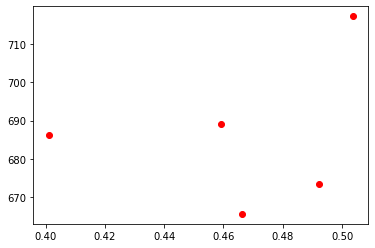

In [17]:
import numpy as np
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1)

# plot the data
ax.plot(combined['binary'],combined['Close'], 'ro')

In [18]:
#import tweepy

#auth = tweepy.OAuthHandler(API_KEY, API_SECRET)
#auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)

#api = tweepy.API(auth)

#public_tweets = api.home_timeline()
#for tweet in public_tweets:
#    print(tweet.text)